### 本文我们将使用由 CrowdFlower提供的一个名为「社交媒体中出现的灾难」的数据集
其中： 编者查看了超过 1万条推文，其中包括「着火」、「隔离」和「混乱」等各种搜索，然后看推文是否是指灾难事件（排除掉用这些单词来讲笑话或评论电影等没有发生灾难的情况）。
我们的任务是检测哪些推文关于灾难性事件，排除像电影这种不相关的话题。为什么？一个可能的应用是仅在发生紧急事件时（而不是在讨论最近 Adam Sandler 的电影时）通知执法官员。这篇文章的其它地方，我们将把关于灾难的推文称为「灾难」，把其它的推文称为「不相关事件」。
依赖数据下载：https://www.crowdflower.com/data-for-everyone/

In [2]:
import codecs
import pandas as pd
import numpy as np
import re
import keras

Using TensorFlow backend.


## 1. 数据收集

In [3]:
input_file = codecs.open('data/socialmedia_relevant_cols.csv','r',encoding = 'utf-8',errors='replace')

In [4]:
output_file = open('data/socialmedia-relevant_cols_clean.csv','w')

In [5]:
def sanitize_characters(raw,clean):
    for line in input_file:
        output_file.write(line)

In [6]:
sanitize_characters(input_file,output_file)

### inspect the data

In [11]:
socialmedia_data  = pd.read_csv('data/socialmedia-relevant_cols_clean.csv')
socialmedia_data.columns = ['text','choose_one','class_label']

In [12]:
socialmedia_data.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [13]:
socialmedia_data.describe()

,class_label
count,10859.000000
mean,0.431808
std,0.498317
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


## 2. 清洗数据
利用regular 表达式清理数据，并保存到data目录，便于后续使用
```
1. 删除所有不相关的字符，例如任何非字母数字字符； 
2. 把你的文章分成一个个单独的单词； 
3. 删除不相关的单词，比如“@”twitter或网址； 
4. 将所有字符转换为小写，以处理诸如“hello”、“Hello”和“HELLO”等单词； 
5. 考虑将拼错的单词或拼写单词组合成一类(如：“cool”/“kewl”/“cooool”)； 
6. 考虑词性还原（将「am」「are」「is」等词语统一为常见形式「be」）
```

In [14]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r'http\S+','')
    df[text_field] = df[text_field].str.replace(r'http','')
    df[text_field] = df[text_field].str.replace(r'@\S+','')
    df[text_field] = df[text_field].str.replace(r'[^A-Za-z0-9(),!?@\`\'\"\_\n]',' ')
    df[text_field] = df[text_field].str.replace(r'@','at')
    return df

In [15]:
socialmedia_data = standardize_text(socialmedia_data,'text')

In [16]:
socialmedia_data.to_csv('data/etl_socialmedia_data.csv')

In [17]:
etl_socialmedia_data = pd.read_csv('data/etl_socialmedia_data.csv')

In [18]:
etl_socialmedia_data.head()

,Unnamed: 0,text,choose_one,class_label
0,0,Just happened a terrible car crash,Relevant,1
1,1,Our Deeds are the Reason of this earthquake M...,Relevant,1
2,2,"Heard about earthquake is different cities, s...",Relevant,1
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,4,Forest fire near La Ronge Sask Canada,Relevant,1


#### 数据预览(分组)

In [19]:
etl_socialmedia_data.groupby('class_label').count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6186,6186,6186
1,4657,4657,4657
2,16,16,16


### 转换

In [21]:
from nltk.tokenize import RegexpTokenizer

In [22]:
tokenizer = RegexpTokenizer(r'\w+')

In [23]:
etl_socialmedia_data['tokens'] = etl_socialmedia_data['text'].apply(tokenizer.tokenize)

In [24]:
etl_socialmedia_data.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,Just happened a terrible car crash,Relevant,1,"[Just, happened, a, terrible, car, crash]"
1,1,Our Deeds are the Reason of this earthquake M...,Relevant,1,"[Our, Deeds, are, the, Reason, of, this, earth..."
2,2,"Heard about earthquake is different cities, s...",Relevant,1,"[Heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,Forest fire near La Ronge Sask Canada,Relevant,1,"[Forest, fire, near, La, Ronge, Sask, Canada]"


### 利用keras 分析数据集

In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import  pad_sequences
from keras.utils import to_categorical

In [26]:
all_words = [word  for tokens in etl_socialmedia_data['tokens'] for word in tokens]

In [28]:
sentence_lens = [len(tokens) for tokens in etl_socialmedia_data['tokens']]

In [30]:
vocab = sorted(list(set(all_words)))

In [32]:
len(all_words)

154484

In [33]:
len(vocab)

23411

In [34]:
max(sentence_lens)

34

### 绘图

In [35]:
import matplotlib.pyplot as plt

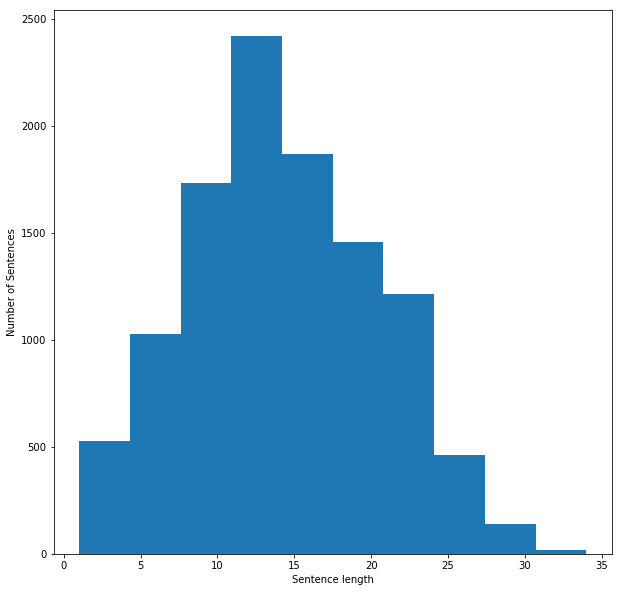

In [36]:
fig = plt.figure(figsize=(10,10))
plt.xlabel('Sentence length')
plt.ylabel('Number of Sentences')
plt.hist(sentence_lens)
plt.show()

### Bag of Words Counts

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [38]:
list_corpus = etl_socialmedia_data['text'].tolist()
list_labels = etl_socialmedia_data['class_label'].tolist()

In [40]:
X_train,X_test,y_train,y_test = train_test_split(list_corpus,list_labels,test_size=0.2,random_state=40)

In [41]:
len(X_test)/len(list_corpus)

0.20001841790220093

In [46]:
def cv(data):
    count_vectorizer  = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb,count_vectorizer

In [67]:
X_train_counts,count_vectorizer = cv(X_train)

In [68]:
X_test_counts = count_vectorizer.transform(X_test)

In [70]:
X_train_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Visualizing the embeddings

In [52]:
from sklearn.decomposition import PCA,TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

In [74]:
def plot_LSA(test_data, test_labels,save_path = 'data/PCA_demo.csv',plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue','blue']
    if plot:
        plt.scatter(lsa_scores[:,0],lsa_scores[:,1],s = 8,alpha=0.8,c=test_labels,cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange',label='Irrelevant')
        green_patch = mpatches.Patch(color='blue',label='Disaster')
        plt.legend(handles=[red_patch,green_patch],prop ={'size':30})    

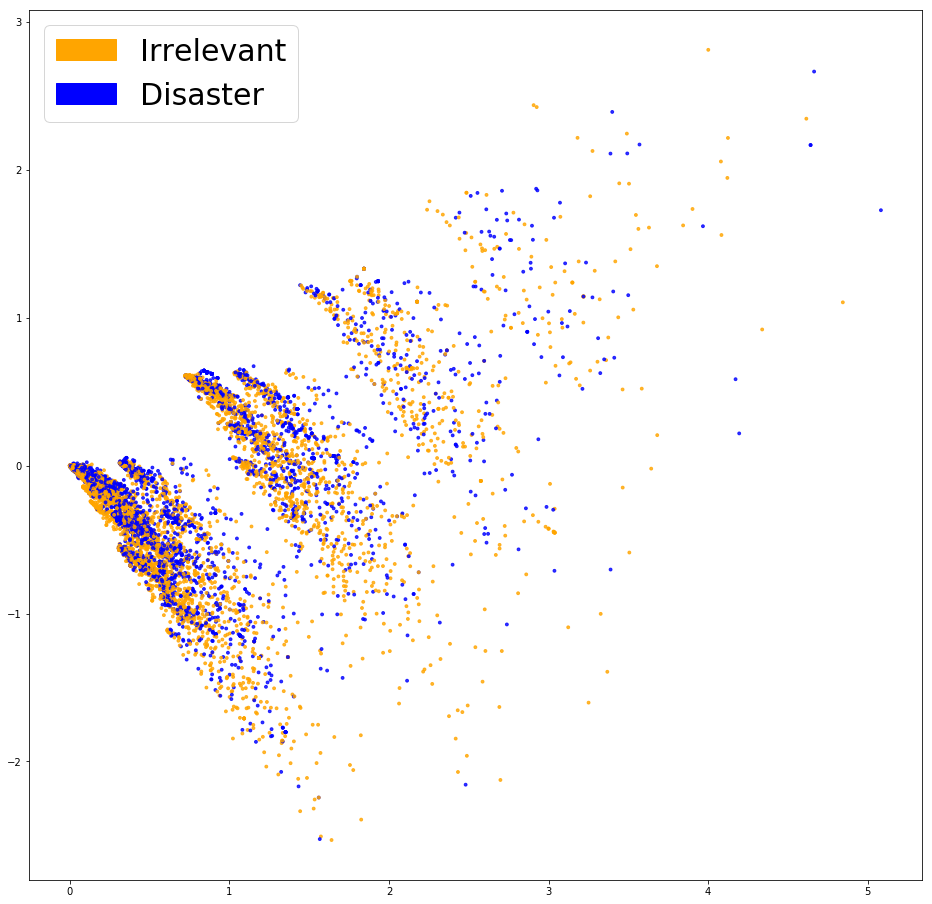

In [75]:
fig = plt.figure(figsize=(16,16))
plot_LSA(X_train_counts,y_train)
plt.show()

### Fitting a classifier

In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
lr = LogisticRegression(C=30.0,class_weight='balanced',solver='newton-cg',multi_class='multinomial',n_jobs=-1,random_state=40)


In [80]:
lr.fit(X_train_counts,y_train)

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [81]:
y_predicted_counts = lr.predict(X_test_counts)

In [82]:
y_predicted_counts

array([0, 0, 1, ..., 1, 1, 1])

### Evaluation

In [83]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report

In [85]:
def get_metrics(y_test,y_predicted):
    # true positives / (true positives + false positives)
    precision = precision_score(y_test,y_predicted,pos_label=None,average='weighted')
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test,y_predicted,pos_label=None,average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test,y_predicted)
    return accuracy,precision,recall,f1

In [86]:
accuracy,precision,recall,f1 = get_metrics(y_test,y_predicted_counts)

In [91]:
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.758, recall = 0.761, f1 = 0.759


In [88]:
precision

0.75785542178311271

In [89]:
recall

0.76058931860036827

In [90]:
f1

0.75906725414884613

### Inspection

In [113]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline
plt.rc('figure', figsize=(10, 6))

In [93]:
cm = confusion_matrix(y_test,y_predicted_counts)

In [94]:
print (cm)

[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [114]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,fontsize=20)
    plt.yticks(tick_marks,classes,fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.0
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

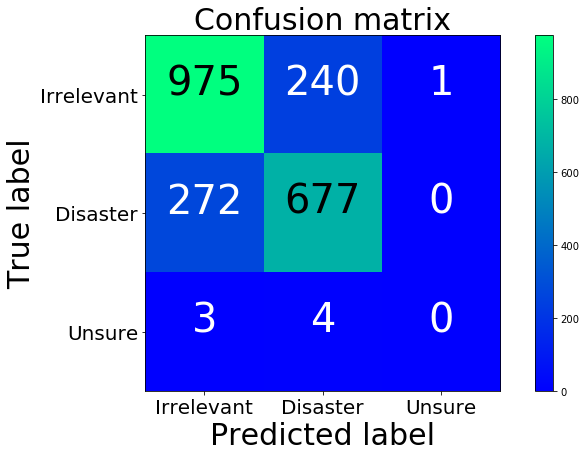

In [115]:
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()

### Further inspection

In [160]:
def get_most_important_features(vectorizer, model, n = 5):
    index_to_word = {v:k for k,v in count_vectorizer.vocabulary_.items()}
    # loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances,key = lambda x: x[0],reverse=True)
        top_n = sorted(sorted_coeff[:n],key = lambda x : x[0])
        bottom_n = sorted_coeff[-n:]
        classes[class_index] = {
            'top_n':top_n,
            'bottom_n':bottom_n
        }
        
    return classes

In [161]:
importance_words = get_most_important_features(count_vectorizer,lr,10)

In [180]:
top_scores = [a[0] for a in importance_words[1]['top_n']]
top_words = [a[1] for a in importance_words[1]['top_n']]

bottom_scores = [a[0] for a in importance_words[1]['bottom_n']]
bottom_words = [a[1] for a in importance_words[1]['bottom_n']]

In [170]:
print(top_scores)

[2.9416018782168365, 2.9754058796693261, 3.0864205920711427, 3.135230765567115, 3.1635390380952222, 3.4013191092952053, 3.4466634461693531, 3.5221577509767252, 3.5239472421677913, 3.7533717044592136]


In [166]:
top_words

['distance',
 'sooooooo',
 'massive',
 'massacre',
 'stealing',
 'stake',
 'typhoon',
 'heyooo',
 'hiroshima',
 '__']

In [168]:
bottom_words

['abcnews',
 'our_mother_mary',
 'kinder',
 'ice',
 'cake',
 'gmail',
 'christmas',
 'tickets',
 'age',
 'see']

In [176]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words,top_scores)]
    top_pairs = sorted(top_pairs,key= lambda x:x[1],reverse=True)
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words,bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key= lambda x:x[1],reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(121)
    plt.barh(y_pos, bottom_scores, align='center',alpha=0.5)
    plt.title('Irrelevant',fontsize = 16)
    plt.yticks(y_pos,bottom_words,fontsize=14)
    plt.suptitle('Key words',fontsize=16)
    plt.xlabel('Importance',fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    

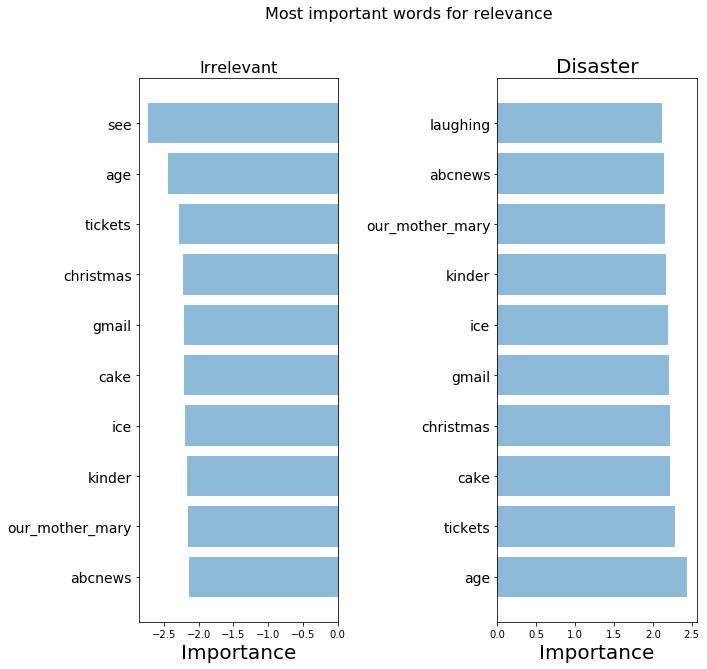

In [181]:
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### TFIDF Bag of Words

In [183]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train,tfidf_vectorizer

In [184]:
X_train_tfidf,tfidf_vectorizer = tfidf(X_train)


In [186]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [188]:
X_train_tfidf.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

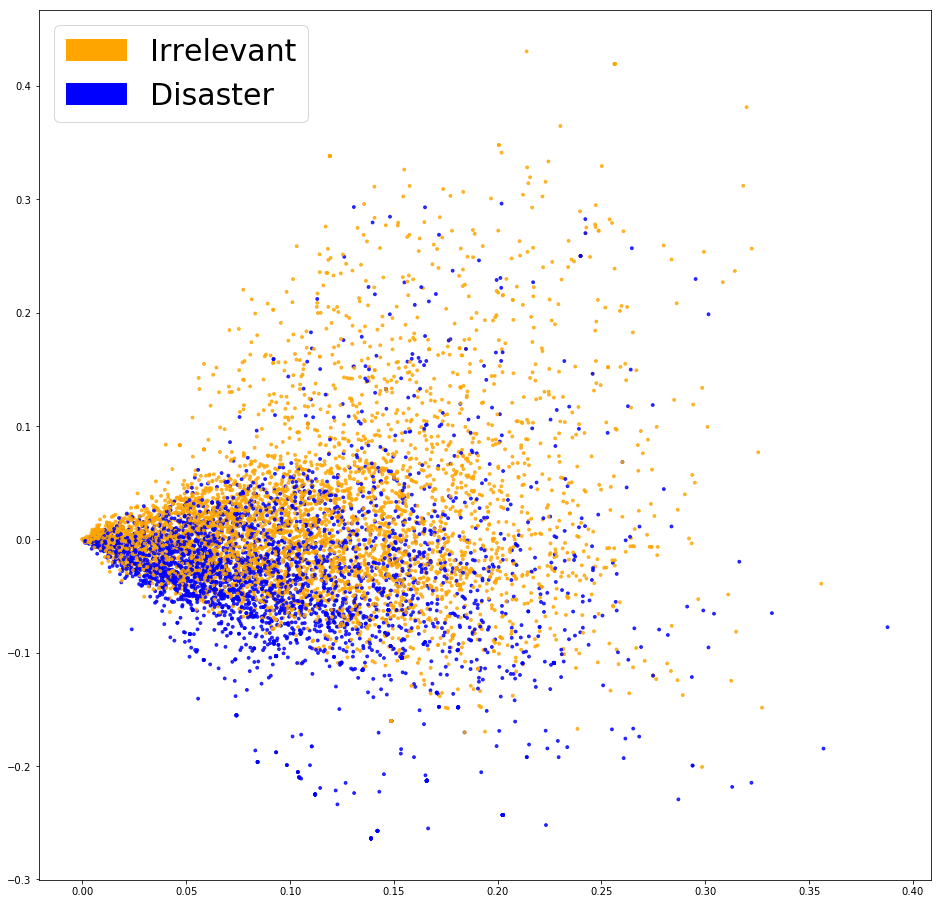

In [189]:
fig = plt.figure(figsize=(16,16))
plot_LSA(X_train_tfidf,y_train)
plt.show()

In [197]:
clf_tfidf = LogisticRegression(C = 30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial',n_jobs=-1,random_state = 40)

In [198]:
clf_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=40, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [203]:
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [200]:
clf_tfidf.intercept_

array([ 2.85515658,  1.44513842, -4.300295  ])

In [204]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)

/home/wangyue/miniconda2/envs/gluon/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wangyue/miniconda2/envs/gluon/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [205]:
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.760, precision = 0.757, recall = 0.760, f1 = 0.758


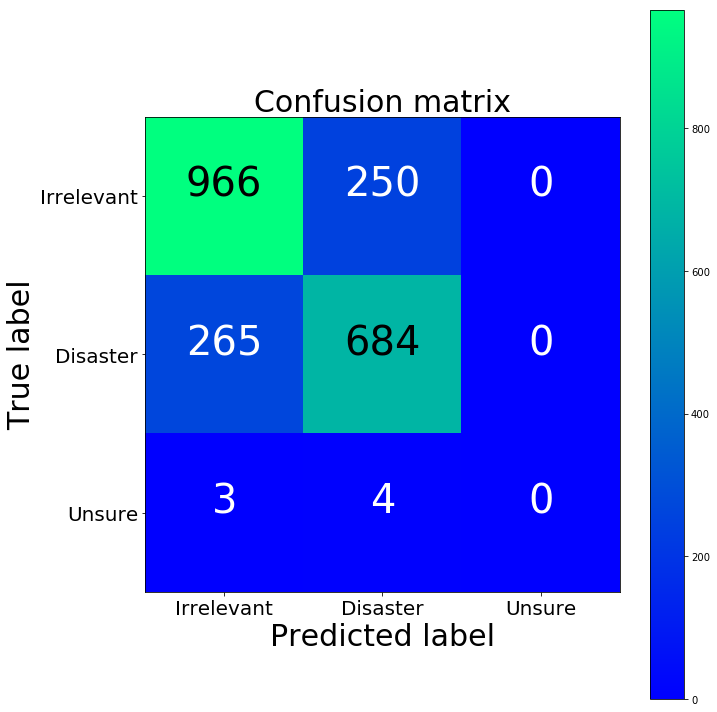

TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
BoW confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [206]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)


### Looking at important coefficients for linear regression

In [207]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

In [210]:
top_scores = [a[0] for a in importance_tfidf[1]['top_n']]
top_words = [a[1] for a in importance_tfidf[1]['top_n']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom_n']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom_n']]

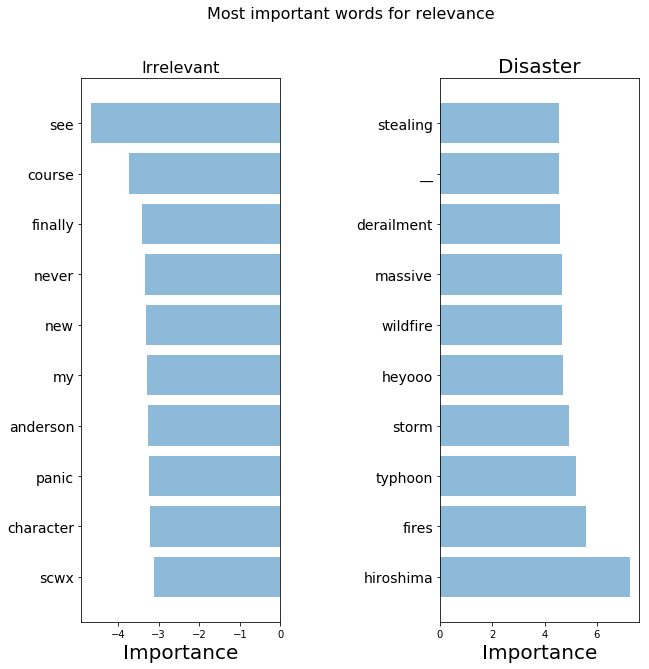

In [211]:
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### Enter word2vec

In [212]:
import gensim

In [213]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vect = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path,binary=True)

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin.gz'